In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%cd /content/drive/MyDrive/Code_Injection_Dataset

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Code_Injection_Dataset'
e:\Work_DatPT\Study\Master\SecBERT


In [4]:
data_dir = 'E:\Work_DatPT\Study\Master\dataset'
df_train = pd.read_csv(data_dir + '/dataset_capec.csv')
df_train.head()

,text,label
0,GET /blog/index.php/2020/04/04/voluptatum-repr...,000 - Normal
1,GET /blog/xmlrpc.php?rsd,000 - Normal
2,GET /blog/index.php/2020/04/04/nihil-tenetur-e...,000 - Normal
3,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal
4,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal


label
66 - SQL Injection                        248093
000 - Normal                              226509
194 - Fake the Source of Data              55982
34 - HTTP Response Splitting               19134
126 - Path Traversal                       17595
242 - Code Injection                       13792
272 - Protocol Manipulation                 6924
310 - Scanning for Vulnerable Software      2382
153 - Input Data Manipulation               1387
Name: count, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '66 - SQL Injection'),
  Text(1, 0, '000 - Normal'),
  Text(2, 0, '194 - Fake the Source of Data'),
  Text(3, 0, '34 - HTTP Response Splitting'),
  Text(4, 0, '126 - Path Traversal'),
  Text(5, 0, '242 - Code Injection'),
  Text(6, 0, '272 - Protocol Manipulation'),
  Text(7, 0, '310 - Scanning for Vulnerable Software'),
  Text(8, 0, '153 - Input Data Manipulation')])

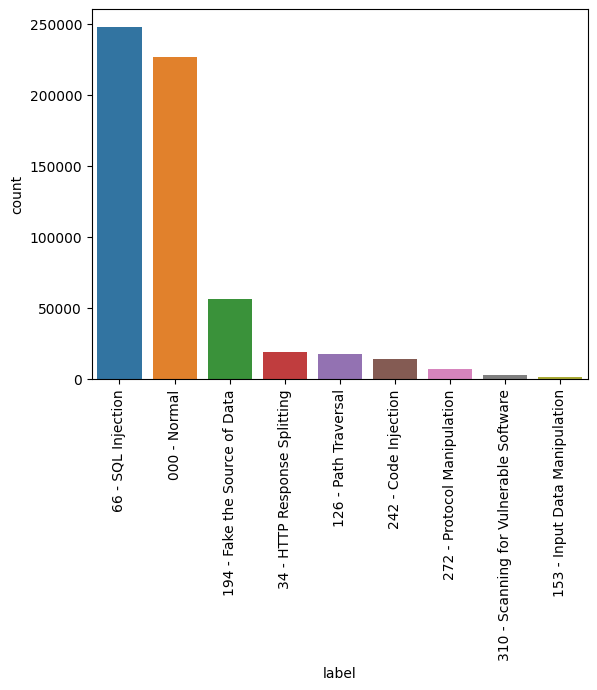

In [5]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['label'].value_counts()
print(x)
sns.barplot(x = x.index, y = x)
plt.xticks(rotation=90)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [7]:
# Optional (not effect very much)
df_train['text'] = df_train['text'].str.replace('/',' ')
df_train.head()

,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


In [8]:
# TF-IDF + NB
# thực hiện quá trình huấn luyện một mô hình phân loại văn bản sử dụng phương pháp TF-IDF 
# để biểu diễn văn bản và mô hình Naive Bayes để phân loại.
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))

0.8683930381885773


In [9]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.81      0.93      0.87     45332
                  126 - Path Traversal       1.00      0.79      0.88      3484
         153 - Input Data Manipulation       0.09      1.00      0.17       247
         194 - Fake the Source of Data       0.98      0.92      0.94     11257
                  242 - Code Injection       0.97      0.91      0.94      2720
           272 - Protocol Manipulation       0.00      0.00      0.00      1393
310 - Scanning for Vulnerable Software       0.96      0.28      0.43       469
          34 - HTTP Response Splitting       0.94      0.92      0.93      3827
                    66 - SQL Injection       0.94      0.83      0.88     49631

                              accuracy                           0.87    118360
                             macro avg       0.74      0.73      0.67    118360
                          weighted avg

In [10]:
## TF-IDF + RF
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9600794187225414


In [11]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45332
                  126 - Path Traversal       1.00      0.93      0.96      3484
         153 - Input Data Manipulation       0.60      0.01      0.02       247
         194 - Fake the Source of Data       1.00      0.93      0.96     11257
                  242 - Code Injection       1.00      0.99      1.00      2720
           272 - Protocol Manipulation       0.65      0.14      0.24      1393
310 - Scanning for Vulnerable Software       0.88      0.99      0.93       469
          34 - HTTP Response Splitting       1.00      1.00      1.00      3827
                    66 - SQL Injection       0.98      0.96      0.97     49631

                              accuracy                           0.96    118360
                             macro avg       0.89      0.77      0.78    118360
                          weighted avg

## Test for unseen data

In [12]:
df_transfer = pd.read_csv(data_dir +'/dataset_capec_transfer.csv')
df_transfer.head()

,text,label
0,POST /vendor/phpunit/phpunit/src/Util/PHP/eval...,153 - Input Data Manipulation
1,POST /cgi-bin/ViewLog.asp remote_submit_Flag=...,153 - Input Data Manipulation
2,GET /.svn/wc.db,153 - Input Data Manipulation
3,GET /blog/.svn/wc.db,153 - Input Data Manipulation
4,GET /blog/index.php/my-account/.svn/wc.db,153 - Input Data Manipulation


In [13]:
df_transfer.label.unique()

array(['153 - Input Data Manipulation', '242 - Code Injection',
       '126 - Path Traversal', '34 - HTTP Response Splitting'],
      dtype=object)

In [14]:
# Optional (not effect very much)
df_transfer['text'] = df_transfer['text'].str.replace('/',' ')
df_transfer.head()

,text,label
0,POST vendor phpunit phpunit src Util PHP eval...,153 - Input Data Manipulation
1,POST cgi-bin ViewLog.asp remote_submit_Flag=...,153 - Input Data Manipulation
2,GET .svn wc.db,153 - Input Data Manipulation
3,GET blog .svn wc.db,153 - Input Data Manipulation
4,GET blog index.php my-account .svn wc.db,153 - Input Data Manipulation


In [15]:
vec = TfidfVectorizer(analyzer='word', input='content', max_features=300)
transfer_feature = vec.fit_transform(df_transfer['text']).toarray()
y_transfer = df_transfer['label']

### 153 bị nhầm nhiều với 242, 126 cũng bị nhầm nhiều với 242 (có nên đổi label của 153 và 126 thành 242?)

In [17]:
y_predict = mnb.predict(transfer_feature)
print(classification_report(y_transfer,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_transfer, y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-sc

                               precision    recall  f1-score   support

                 000 - Normal       0.00      0.00      0.00         0
         126 - Path Traversal       0.00      0.00      0.00       167
153 - Input Data Manipulation       0.00      0.00      0.00      1950
194 - Fake the Source of Data       0.00      0.00      0.00         0
         242 - Code Injection       0.98      0.09      0.16      9168
  272 - Protocol Manipulation       0.00      0.00      0.00         0
 34 - HTTP Response Splitting       0.51      0.20      0.29       534
           66 - SQL Injection       0.00      0.00      0.00         0

                     accuracy                           0.08     11819
                    macro avg       0.19      0.04      0.06     11819
                 weighted avg       0.78      0.08      0.14     11819

Confusion Matrix: 
 [[   0    0    0    0    0    0    0    0]
 [   4    0    0    0    0    0    0  163]
 [ 441    0    0   57   15    0   17 14

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(rf.score(transfer_feature, y_transfer))

0.08528640324900584


## 126 bị nhầm nhiều với 242, 194 bị nhầm nhiều với 310, 34 bị nhầm nhiều với 194

In [19]:
y_predict = rf.predict(transfer_feature)
print(classification_report(y_transfer,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_transfer, y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-sc

                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00         0
                  126 - Path Traversal       0.00      0.00      0.00       167
         153 - Input Data Manipulation       0.00      0.00      0.00      1950
         194 - Fake the Source of Data       0.00      0.00      0.00         0
                  242 - Code Injection       0.98      0.09      0.16      9168
           272 - Protocol Manipulation       0.00      0.00      0.00         0
310 - Scanning for Vulnerable Software       0.00      0.00      0.00         0
          34 - HTTP Response Splitting       0.85      0.38      0.53       534
                    66 - SQL Injection       0.00      0.00      0.00         0

                              accuracy                           0.09     11819
                             macro avg       0.20      0.05      0.08     11819
                          weighted avg

## Deep Neural Nets

In [20]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [21]:
import tensorflow as tf

In [22]:
## Reduce data for testing
df_242 = df_train[(df_train['label'] == '242 - Code Injection')]
df_242 = df_242.sample(frac = 1)
df_242 = df_242[:50000]
df_000 = df_train[(df_train['label'] == '000 - Normal')]
df_000 = df_000.sample(frac = 1)
df_000 = df_000[:50000]

In [23]:
df_sub = df_train[(df_train['label'] != '000 - Normal') & (df_train['label'] != '242 - Code Injection')]

In [24]:
df_train = pd.concat([df_train,df_242,df_000], ignore_index=True)

In [25]:
possible_labels = df_train.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'000 - Normal': 0,
 '126 - Path Traversal': 1,
 '66 - SQL Injection': 2,
 '272 - Protocol Manipulation': 3,
 '310 - Scanning for Vulnerable Software': 4,
 '242 - Code Injection': 5,
 '153 - Input Data Manipulation': 6,
 '194 - Fake the Source of Data': 7,
 '34 - HTTP Response Splitting': 8}

In [26]:
df_train['label_int'] = df_train.label.replace(label_dict)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label_int"],
                                                  test_size=0.2,
                                                  shuffle=True)

w2v = Word2Vec([sentence.lower().split() for sentence in x_train.values])

maxlen = 100
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train_sequences, 
                                maxlen=100,
                                padding='post',
                                truncating='post')

x_test = pad_sequences(x_test_sequences,
                             maxlen=100,
                             padding='post',
                             truncating='post')

embedding_matrix = np.zeros((len(word_index)+1, 100))
for word,i in word_index.items():
    try:
        embedding_matrix[i] = w2v.wv[i]
    except:
        embedding_matrix[i] = np.zeros(100)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=100,
        weights=[embedding_matrix]),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', metrics=['acc'], 
        loss='sparse_categorical_crossentropy')
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)

In [35]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)

Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "e:\Python\Lib\asyncio\base_events.py", line 607, in run_forever

  File "e:\Python\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "e:\Python\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\ngngo\AppData\Local\Temp\ipykernel_14936\2069719752.py", line 1, in <module>

  File "e:\Python\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "e:\Python\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "e:\Python\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "e:\Python\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "e:\Python\Lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "e:\Python\Lib\site-packages\keras\src\backend.py", line 5777, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 7).  Label values: 0 2 2 0 0 2 2 0 2 4 2 7 0 2 7 2 2 0 0 0 2 0 7 2 0 2 1 2 2 3 0 2
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_21374]

In [36]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("acc: ", results[1])

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "e:\Python\Lib\asyncio\base_events.py", line 607, in run_forever

  File "e:\Python\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "e:\Python\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\ngngo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\ngngo\AppData\Local\Temp\ipykernel_14936\2300355267.py", line 1, in <module>

  File "e:\Python\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 2272, in evaluate

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 4079, in run_step

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 2042, in test_function

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 2025, in step_function

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 2013, in run_step

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1895, in test_step

  File "e:\Python\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "e:\Python\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "e:\Python\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "e:\Python\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "e:\Python\Lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "e:\Python\Lib\site-packages\keras\src\backend.py", line 5777, in sparse_categorical_crossentropy

Received a label value of 8 which is outside the valid range of [0, 7).  Label values: 0 2 2 0 0 5 7 2 5 0 2 0 2 2 0 7 7 0 0 2 2 0 2 1 0 5 0 0 2 0 2 8 2 7 2 0 0 0 7 1 2 5 2 2 0 0 2 0 0 2 0 0 2 7 0 2 5 0 0 0 2 2 7 2 0 8 2 2 1 7 7 2 3 0 0 0 0 0 7 0 2 0 2 2 7 0 0 0 0 0 2 0 7 2 0 0 0 2 0 2 0 0 0 2 0 5 0 0 2 2 0 2 0 2 2 2 1 0 2 8 2 2 0 0 2 0 0 7
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_22043]

In [ ]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]



In [ ]:
from sklearn.metrics import classification_report

y_pred = predict_class(x_test)

print(classification_report(y_test, y_pred))

In [ ]:
df_transfer['int_label'] = 0

In [ ]:
w2v = Word2Vec([sentence.lower().split() for sentence in df_transfer['text'].values])

maxlen = 100
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_transfer['text'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

x_train_sequences = tokenizer.texts_to_sequences(df_transfer['text'])

x_transfer = pad_sequences(x_train_sequences, 
                                maxlen=100,
                                padding='post',
                                truncating='post')

In [ ]:
print(1 - model.evaluate(x_transfer, df_transfer['int_label'], batch_size=128)[1])